# Project Name : *`Human Emotions Detection`*

**Project Title: Emotion Classification Using Image Data**

### Project Description:
In this project, we aim to develop a machine learning model that classifies emotions displayed in images into three categories: **angry**, **sad**, and **happy**. By leveraging labeled image data sourced from Kaggle, the project focuses on training a model capable of interpreting and categorizing emotions based on facial expressions. This system has broad applications in human-computer interaction, mental health monitoring, and social robotics, where understanding human emotions plays a crucial role.

### Objectives:
1. **Data Collection**:
   The dataset contains labeled images categorized into three classes:
   - **Angry**: Images where the subject displays anger.
   - **Sad**: Images where the subject expresses sadness.
   - **Happy**: Images where the subject appears joyful.

   This data serves as the foundation for training and evaluating the model.

2. **Preprocessing and Data Preparation**:
   - **Image Normalization**: Standardizing pixel values to improve model performance.
   - **Augmentation**: Enhancing the dataset by applying transformations such as rotation, flipping, and zooming to improve the model's ability to generalize.
   - **Class Balancing**: Ensuring that the dataset is balanced across the three classes to prevent bias during training.

3. **Model Development**:
   We will design and train a deep learning model capable of emotion classification. The project will explore different architectures, such as:
   - Convolutional Neural Networks (CNNs): Suitable for extracting spatial features from images.
   - Pretrained Models (e.g., VGG, ResNet, EfficientNet): Leveraging transfer learning to improve accuracy and reduce training time.

4. **Evaluation Metrics**:
   The model's performance will be assessed using:
   - **Accuracy**: Overall percentage of correct predictions.
   - **Precision, Recall, and F1-Score**: Class-specific metrics to evaluate performance in imbalanced scenarios.
   - **Confusion Matrix**: For detailed insights into misclassifications.

5. **Deployment**:
   Once the model is trained and evaluated, it will be packaged into a user-friendly application for real-time emotion classification. This may involve deploying the model using platforms like Flask, Gradio, or Streamlit.

### Challenges and Considerations:
- **Variability in Facial Expressions**: Differences in lighting, angle, and individual facial features can affect model performance.
- **Class Imbalance**: If one emotion class dominates the dataset, it may skew the model's predictions.
- **Overfitting**: Risk of overfitting due to limited variability in the training data.
- **Generalization**: Ensuring the model performs well on unseen data.

### Expected Outcomes:
1. A robust model capable of classifying emotions into **angry**, **sad**, or **happy** with high accuracy.
2. Insights into the most significant features or patterns associated with each emotion.
3. A deployable application for real-time emotion recognition, with potential integration into broader systems like mental health monitoring or customer feedback analysis.

### Applications:
- **Mental Health**: Automated emotion detection for identifying individuals in distress.
- **Education**: Understanding student emotions in online learning environments.
- **Customer Interaction**: Enhancing user experience by adapting systems based on emotional cues.
- **Entertainment**: Personalizing content recommendations based on viewer emotions.

This project not only addresses a fascinating computer vision challenge but also contributes to real-world applications where emotional understanding is pivotal.



## 1. Make necessary imports
Let's import the required libaries for performing this task.

In [1]:
!wget 'https://github.com/krutika-shimpi/Human_Emotion_Detection_Project/raw/main/helper_functions.py'

--2025-02-08 09:22:39--  https://github.com/krutika-shimpi/Human_Emotion_Detection_Project/raw/main/helper_functions.py
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/krutika-shimpi/Human_Emotion_Detection_Project/main/helper_functions.py [following]
--2025-02-08 09:22:39--  https://raw.githubusercontent.com/krutika-shimpi/Human_Emotion_Detection_Project/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7796 (7.6K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   7.61K  --.-KB/s    in 0s      

2025-02-08 09:22:39 (104 MB/s) 

In [52]:
from helper_functions import make_confusion_matrix, plot_loss_curves
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

### 1.1 Setup global variables

Let's set some Global Variables that we will be using throughout the project.

In [3]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [4]:
# Setup some global variables that we will be using throughout
CLASS_NAMES = ['angry', 'happy','sad']
CONFIGURATION = {
    'BATCH_SIZE' : 32,
    'IM_SIZE' : 256,
    'LEARNING_RATE' : 1e-3,
    'N_EPOCHS' : 20,
    'N_DENSE_1' : 1024,
    'N_DENSE_2' : 128,
    'DROPOUT_RATE' : 0.0,
    'REGULARIZATION_RATE' : 0.0,
    'N_STRIDES' : 1,
    'POOL_SIZE' : 2,
    'N_FILTERS' : 6,
    'KERNEL_SIZE' : 3,
    'NUM_CLASSES' : 3,
    'CLASS_NAMES' : ['angry', 'happy','sad']
}

## 2. Get the Data

The dataset is provided on Kaggle by Mohammed Muhammadhananasghar. Please find the link below:

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
100% 309M/309M [00:02<00:00, 158MB/s]
100% 309M/309M [00:02<00:00, 114MB/s]


In [6]:
!unzip "/content/human-emotions-datasethes.zip"

Streaming output truncated to the last 5000 lines.
  inflating: EmotionsDataset/data/nothing/720.jpg  
  inflating: EmotionsDataset/data/nothing/721.jpg  
  inflating: EmotionsDataset/data/nothing/722.jpg  
  inflating: EmotionsDataset/data/nothing/723.jpg  
  inflating: EmotionsDataset/data/nothing/724.jpg  
  inflating: EmotionsDataset/data/nothing/725.jpg  
  inflating: EmotionsDataset/data/nothing/726.jpg  
  inflating: EmotionsDataset/data/nothing/727.jpg  
  inflating: EmotionsDataset/data/nothing/728.jpg  
  inflating: EmotionsDataset/data/nothing/729.jpg  
  inflating: EmotionsDataset/data/nothing/73.jpg  
  inflating: EmotionsDataset/data/nothing/730.jpg  
  inflating: EmotionsDataset/data/nothing/731.jpg  
  inflating: EmotionsDataset/data/nothing/732.jpg  
  inflating: EmotionsDataset/data/nothing/733.jpg  
  inflating: EmotionsDataset/data/nothing/734.jpg  
  inflating: EmotionsDataset/data/nothing/735.jpg  
  inflating: EmotionsDataset/data/nothing/736.jpg  
  inflating: E

## 3. Creating TensorFlow datasets

We will create a TensorFlow dataset from our image data using the `tf.keras.utils.image_dataset_from_directory` function, which efficiently loads and preprocesses image files directly from the directory structure.

This function will automatically label the images based on their folder names, making it convenient for training and validation processes.

In [7]:
# Setup train and val dir
train_dir =  '/content/Emotions Dataset/Emotions Dataset/train'
val_dir = '/content/Emotions Dataset/Emotions Dataset/test'

In [29]:
# Create the train dataset using the `tf.keras.utils.image_dataset_from_directory` for efficiently loading the data
train_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    labels ='inferred', # The emotion class will be inferred from the directory name
    label_mode = 'categorical', # Use integer encoding for output classes if set as 'int' (angry, happy, sad), categorical will use onehot representation
    class_names = CONFIGURATION['CLASS_NAMES'],
    color_mode = 'rgb',
    batch_size = 32,
    image_size = (256, 256),
    shuffle = True,
    seed = 99
)

# Create the val dataset in the same way
val_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    directory = val_dir,
    labels ='inferred', # The emotion class will be inferred from the directory name
    label_mode = 'categorical', # categorical will use onehot representation
    class_names = CONFIGURATION['CLASS_NAMES'],
    color_mode = 'rgb',
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle = True,
    seed = 99
)

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


In [9]:
for i in train_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[115.       , 115.       , 115.       ],
         [110.9375   , 110.9375   , 110.9375   ],
         [111.375    , 111.375    , 111.375    ],
         ...,
         [ 40.3125   ,  40.3125   ,  40.3125   ],
         [ 41.1875   ,  41.1875   ,  41.1875   ],
         [ 42.       ,  42.       ,  42.       ]],

        [[115.       , 115.       , 115.       ],
         [112.25781  , 112.25781  , 112.25781  ],
         [110.765625 , 110.765625 , 110.765625 ],
         ...,
         [ 41.683594 ,  41.683594 ,  41.683594 ],
         [ 41.847656 ,  41.847656 ,  41.847656 ],
         [ 42.       ,  42.       ,  42.       ]],

        [[115.6875   , 115.6875   , 115.6875   ],
         [113.80859  , 113.80859  , 113.80859  ],
         [110.58203  , 110.58203  , 110.58203  ],
         ...,
         [ 41.570312 ,  41.570312 ,  41.570312 ],
         [ 40.496094 ,  40.496094 ,  40.496094 ],
         [ 39.9375   ,  39.9375   ,  39.9375

## 4. Visualize, visualize & visualize.

Now that we have converted our data into TensorFlow Dataset, let's explore the dataset by visualizing it.

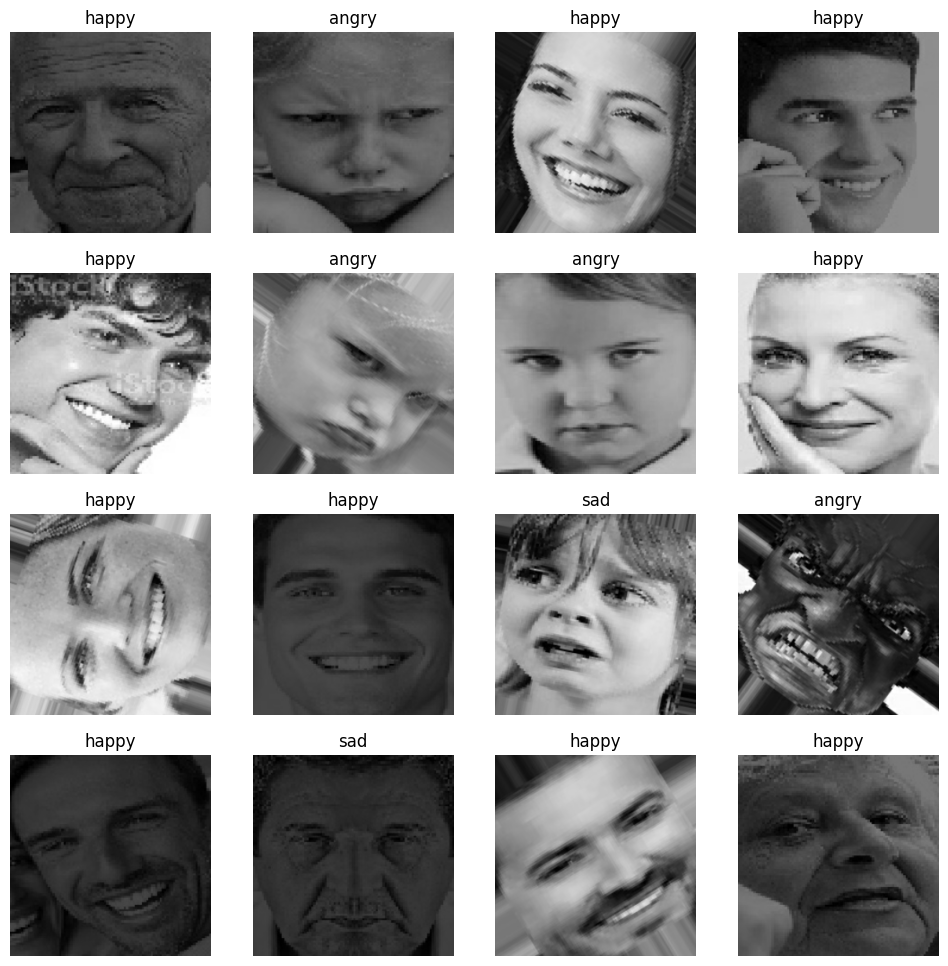

In [11]:
plt.figure(figsize = (12, 12))
for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis('off')

## 6. Data Augmentation

Let's apply data augmentation to reduce the model's overfitting.

In [30]:
# Setup a resize and rescale layer
resize_rescaling_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    Rescaling(1./255)
])

`@tf.function` Decorator

This converts the function into a TensorFlow graph for optimization.
It speeds up execution by compiling it into a TensorFlow graph.

In [31]:
# Create a data augmentation layer using TensorFlow
data_augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.025, 0.025)),
    RandomFlip('horizontal',),
    RandomContrast(factor=0.1)
])

@tf.function
def augment_layer(image, label):
  return data_augment_layers(resize_rescaling_layers(image), training = True), label

### 6.1 Cutmix Data Augmentation

In [32]:
# Defining the bounding box function for cutmix augmentation
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [33]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

## 5. Data Preparation

Prepare efficient data pipelines for training.

In [36]:
# Prepare efficient data pipelines
train_data = train_dataset.prefetch(tf.data.AUTOTUNE)
val_data = val_dataset.prefetch(tf.data.AUTOTUNE)

In [37]:
# Prepare efficient data pipelines
training_dataset = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
validation_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

### Data Preparation for cutmix augmentation

In [ ]:
# Prepare the data for cutmix
train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [ ]:
# Applying cutmix augmentation
training_dataset = (
    mixed_dataset
    .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

validation_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

##  Modelling
Let's start out modelling experiment with Lenet Model Architecture.

### Lenet Model

In [ ]:
# Lets create Lenet Model
lenet_model = tf.keras.models.Sequential([
    InputLayer(shape = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3)),
    resize_rescaling_layers,

    # 1st Conv2D Layer
    Conv2D(filters = CONFIGURATION['N_FILTERS'],
           kernel_size = CONFIGURATION['KERNEL_SIZE'],
           strides = CONFIGURATION['N_STRIDES'],
           kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE']),
           activation = 'relu'),

    BatchNormalization(),
    MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'],
              strides = CONFIGURATION['N_STRIDES'] * 2),
    Dropout(rate = CONFIGURATION['DROPOUT_RATE']),

    # 2nd Conv2D Layer
    Conv2D(filters = CONFIGURATION['N_FILTERS'] * 2 + 4,
           kernel_size = CONFIGURATION['KERNEL_SIZE'],
           strides = CONFIGURATION['N_STRIDES'],
           kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE']),
           activation = 'relu'),

    BatchNormalization(),
    MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'],
              strides = CONFIGURATION['N_STRIDES'] * 2),

    # Flatten Layer
    Flatten(),

    # 1st Dense Layer
    Dense(units = CONFIGURATION['N_DENSE_1'],
          activation = 'relu',
          kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),

    BatchNormalization(),
    Dropout(rate = CONFIGURATION['DROPOUT_RATE']),

    # 2nd Dense Layer
    Dense(units = CONFIGURATION['N_DENSE_2'],
          activation = 'relu',
          kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),

    BatchNormalization(),

    # Output Layer
    Dense(units = CONFIGURATION['NUM_CLASSES'],
          activation = 'softmax')
])

lenet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      62,981,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,118,451 (240.78 MB)

 Trainable params: 63,116,103 (240.77 MB)

 Non-trainable params: 2,348 (9.17 KB)

Setup loss and metrics for the training.
1. Loss: In this case we are using categorical crossentropy loss since we have set our output classes to be categorical which represents the classes as one hot vectors [0,0,0] - Angry, [0,0,1] = Sad, [0,1,0] = Happy

2. Metrics = We are defining categorical accuracy to check whether predicted category is close to actual category.
Moreover, we are setting up Top_k_accuracy to see whether the top k classes with higher probability are close to actual value or not.

### Compile and Train the model

In [ ]:
# Setup loss and metrics
loss = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name = 'Categorical_Accuracy'), TopKCategoricalAccuracy(k = 2, name = 'Top_k_Accuracy')]

In [ ]:
# Compile the model
lenet_model.compile(optimizer = Adam(CONFIGURATION['LEARNING_RATE']),
                    loss = loss,
                    metrics = metrics)

#### With Data Augmentation

In [ ]:
# Fit the model
lenet_model_history = lenet_model.fit(train_dataset,
                                             validation_data = val_dataset,
                                             epochs = CONFIGURATION['N_EPOCHS'],
                                            )

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - Categorical_Accuracy: 0.5104 - Top_k_Accuracy: 0.7984 - loss: 1.1132 - val_Categorical_Accuracy: 0.4078 - val_Top_k_Accuracy: 0.7015 - val_loss: 1.0952
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - Categorical_Accuracy: 0.7093 - Top_k_Accuracy: 0.9083 - loss: 0.6847 - val_Categorical_Accuracy: 0.4991 - val_Top_k_Accuracy: 0.7744 - val_loss: 1.2399
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - Categorical_Accuracy: 0.8366 - Top_k_Accuracy: 0.9618 - loss: 0.4225 - val_Categorical_Accuracy: 0.3819 - val_Top_k_Accuracy: 0.5909 - val_loss: 4.1306
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - Categorical_Accuracy: 0.8799 - Top_k_Accuracy: 0.9718 - loss: 0.3327 - val_Categorical_Accuracy: 0.5040 - val_Top_k_Accuracy: 0.7792 - val_loss: 1.3344
Epoch 5/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - Categorical_Accuracy: 0.9073 - Top_k_Accuracy: 0.9833 - loss: 0.2656 - val_Categorical_Accuracy: 0.6809 - val_To

#### With Cutmix Data Augmentation

In [ ]:
# Lets create Lenet Model for cutmix data augmentation
lenet_model_cutmix = tf.keras.models.Sequential([
    InputLayer(shape = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3)),
    resize_rescaling_layers,

    # 1st Conv2D Layer
    Conv2D(filters = CONFIGURATION['N_FILTERS'],
           kernel_size = CONFIGURATION['KERNEL_SIZE'],
           strides = CONFIGURATION['N_STRIDES'],
           kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE']),
           activation = 'relu'),

    BatchNormalization(),
    MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'],
              strides = CONFIGURATION['N_STRIDES'] * 2),
    Dropout(rate = CONFIGURATION['DROPOUT_RATE']),

    # 2nd Conv2D Layer
    Conv2D(filters = CONFIGURATION['N_FILTERS'] * 2 + 4,
           kernel_size = CONFIGURATION['KERNEL_SIZE'],
           strides = CONFIGURATION['N_STRIDES'],
           kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE']),
           activation = 'relu'),

    BatchNormalization(),
    MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'],
              strides = CONFIGURATION['N_STRIDES'] * 2),

    # Flatten Layer
    Flatten(),

    # 1st Dense Layer
    Dense(units = CONFIGURATION['N_DENSE_1'],
          activation = 'relu',
          kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),

    BatchNormalization(),
    Dropout(rate = CONFIGURATION['DROPOUT_RATE']),

    # 2nd Dense Layer
    Dense(units = CONFIGURATION['N_DENSE_2'],
          activation = 'relu',
          kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),

    BatchNormalization(),

    # Output Layer
    Dense(units = CONFIGURATION['NUM_CLASSES'],
          activation = 'softmax')
])

lenet_model_cutmix.summary()

In [ ]:
# Compile the model
lenet_model_cutmix.compile(loss = tf.keras.losses.CategoricalCrossentropy,
                           optimizer = tf.keras.optimizers.Adam(CONFIGURATION['LEARNING_RATE']),
                           metrics = [CategoricalAccuracy(name = 'Categorical_Accuracy'), TopKCategoricalAccuracy(k = 2, name = 'Top_k_Accuracy')])
# Fit the model
lenet_model_history_cutmix = lenet_model_cutmix.fit(training_dataset,
                                      validation_data = validation_dataset,
                                      epochs = CONFIGURATION['N_EPOCHS'],
                                      )

### 6.3 ResNet Model

Let us now create ResNet architecture with model subclassing.

#### 6.3.1 Residual Block

##### **Description of the `ResidualBlock` Class**

The `ResidualBlock` class implements a residual block, a key component of ResNet architectures, to enhance deep neural network training by allowing identity mappings through skip connections. This helps mitigate the vanishing gradient problem and improves convergence speed.

\

**Residual Block**

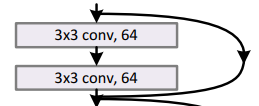

\
##### **Class Breakdown**
1. `Initialization (__init__ method)`

* **Inputs:**
  1. `n_channels:` Number of output channels for the convolutional layers.
  2. `n_strides:` Stride value for downsampling (default = 1).

* **Operations:**
* Defines two 3×3 convolutional layers (`custom_conv_1`, `custom_conv_2`) with the given number of channels.
* Uses ReLU activation to introduce non-linearity.
* If `n_strides ≠ 1`, it sets `self.dotted = True`, indicating that the input dimensions must be adjusted using a 1×1 convolution (`custom_conv_3`).

  **If Dotted**

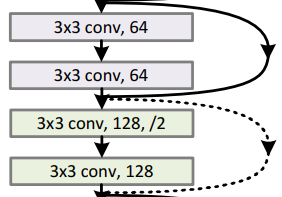

\
2. **Forward Pass (`call` method)**
* **Step 1:** Passes the input through `custom_conv_1` and `custom_conv_2`.
* **Step 2:**
  1. If `self.dotted` is `True` (stride > 1), applies 1×1 convolution (`custom_conv_3`) to downsample the input before addition.
  2. Otherwise, directly adds the input to maintain the same dimensions.
* **Step 3:** Applies element-wise addition to merge the residual connection.
* **Step 4:** Activates the result using ReLU to introduce non-linearity.


In [56]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_filters = n_channels,
                                      kernel_size = 3,
                                      n_strides = n_strides,
                                      padding = 'same')

    self.custom_conv_2 = CustomConv2D(n_filters = n_channels,
                                      kernel_size = 3,
                                      n_strides = 1,
                                      padding = 'same')

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_filters = n_channels,
                                        kernel_size = 1,
                                        n_strides = n_strides)

  # Define the call method to perform forward pass
  def call(self, input, training):
    # Pass input through conv layers, removing the training keyword argument
    x = self.custom_conv_1(input, training = training)
    x = self.custom_conv_2(x, training = training)

    # If dotted is True, apply 1x1 convolution (custom_conv_3) to adjust input dimensions before addition.
    if self.dotted:
      x_add = self.custom_conv_3(input, training = training)
      x_add = Add()([x, x_add])

    else:
      x_add = Add()([x, input])

    return self.activation(x_add)

#### 6.3.2 Custom Conv2D layer

##### **Description of `CustomConv2D` Class**

The `CustomConv2D` class is a custom implementation of a **Convolutional Layer** that integrates a **Batch Normalization layer** after a **2D Convolutional Layer**. This helps improve model training by normalizing activations and reducing internal covariate shift.


* The convolutional layer applies a **filter of given size and stride** to extract spatial features.
* The batch normalization layer normalizes the output, stabilizing training and accelerating convergence.
* **ReLU activation** is applied within the convolution operation for non-linearity.
* This class **inherits from** `Layer` and is designed to be reusable in deep networks like **ResNet**.

In [57]:
# Define a custom convolutional layer with batch normalization
class CustomConv2D(Layer):  # Should inherit from 'Layer' not 'Layers'
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    """
    Initializes the CustomConv2D layer.

    Args:
        n_filters (int): Number of filters (channels) in the convolution layer.
        kernel_size (int or tuple): Size of the convolutional kernel.
        n_strides (int): Stride of the convolution operation.
        padding (str): Padding type ('same' or 'valid').

    """
    # Call parent class constructor and assign a custom name
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    # Define the convolutional layer with given parameters
    self.conv = Conv2D(filters = n_filters,
                       kernel_size = kernel_size,
                       strides = n_strides,
                       padding = padding,
                       activation = 'relu')  # ReLU activation function

    # Batch Normalization layer to stabilize training
    self.batch_norm = BatchNormalization()

  def call(self, x, training=True):
    """
    Defines the forward pass of the CustomConv2D layer.

    Args:
        x (tensor): Input tensor.
        training (bool): Flag to indicate whether it's training or inference mode.

    Returns:
        tensor: Processed tensor after applying convolution and batch normalization.
    """
    x = self.conv(x)       # Apply convolution operation
    x = self.batch_norm(x, training = training) # Normalize activations using batch normalization
    return x

#### 6.3.3

##### **Description of ResNet-34 Architecture**
The `ResNet34` class defines a **Residual Neural Network (ResNet-34)**, a deep convolutional model designed for efficient feature extraction and classification. It follows the **ResNet family** structure, which uses **residual blocks** to enable deeper networks while mitigating the vanishing gradient problem through **skip connections**.

##### **Key Architectural Components**
* **Initial Convolution & Pooling**

  1. A **7x7 convolutional layer** (stride=2) extracts **low-level spatial features.**
  2. A **3x3 max pooling layer** (stride=2) reduces spatial dimensions.

* **Residual Block Groups**

  1. First group (64 filters, 3 blocks): Identity shortcut, no downsampling.
  2. Second group (128 filters, 4 blocks): First block downsamples (stride=2).
  3. Third group (256 filters, 6 blocks): First block downsamples (stride=2).
  4. Fourth group (512 filters, 3 blocks): First block downsamples (stride=2).
  5. Each block consists of two 3x3 convolutional layers with ReLU activation.

* **Global Average Pooling**

  1. Converts the final feature map into a single **1D vector**, reducing parameters.

* **Fully Connected Layer**

  1. Maps the extracted features to CONFIGURATION["NUM_CLASSES"] using softmax activation for classification.
  2. Forward Pass (call Method)
  3. Passes input through convolution + pooling layers.
  4. Processes each residual block group sequentially.
  5. Applies global average pooling to flatten features.
  6. Uses a final fully connected layer for classification.

This architecture balances depth (34 layers) and efficiency, making it ideal for image classification tasks. 🚀

In [58]:
# Define ResNet-34 model by subclassing tf.keras.Model
class ResNet34(Model):
  def __init__(self):
    # Initialize the base Model class and assign a name to this model
    super(ResNet34, self).__init__(name='resnet34')

    # Initial Convolution Layer: 7x7 kernel, stride 2, to extract low-level features
    self.conv_1 = CustomConv2D(n_filters = 64,
                               kernel_size = 7,
                               n_strides = 2,
                               padding = 'same')  # Ensure output size matches expected dimensions

    # Max Pooling Layer: 3x3 kernel, stride 2, to reduce spatial dimensions
    self.max_pool = MaxPooling2D(pool_size = 3,
                                 strides = 2)

    # First Residual Block Group (3 blocks, no downsampling)
    self.conv_2_1 = ResidualBlock(64)  # Uses identity shortcut
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    # Second Residual Block Group (4 blocks, downsample at first block)
    self.conv_3_1 = ResidualBlock(128, 2)  # Downsampling occurs here (stride=2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    # Third Residual Block Group (5 blocks, downsample at first block)
    self.conv_4_1 = ResidualBlock(256, 2)  # Downsampling occurs here
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    # Fourth Residual Block Group (3 blocks, downsample at first block)
    self.conv_5_1 = ResidualBlock(512, 2)  # Downsampling occurs here
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    # Global Average Pooling Layer: Reduces spatial dimensions to 1x1
    self.global_pool = GlobalAveragePooling2D()

    # Fully Connected Layer: Maps to the number of classes using softmax activation
    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation='softmax')

  # Define the forward pass for the model
  def call(self, x, training = True):
    x = self.conv_1(x)    # Initial convolution
    x = self.max_pool(x)  # Apply max pooling

    # Apply the first residual block group
    x = self.conv_2_1(x, training = training)
    x = self.conv_2_2(x, training = training)
    x = self.conv_2_3(x, training = training)

    # Apply the second residual block group
    x = self.conv_3_1(x, training = training)
    x = self.conv_3_2(x, training = training)
    x = self.conv_3_3(x, training = training)
    x = self.conv_3_4(x, training = training)

    # Apply the third residual block group
    x = self.conv_4_1(x, training = training)
    x = self.conv_4_2(x, training = training)
    x = self.conv_4_3(x, training = training)
    x = self.conv_4_4(x, training = training)
    x = self.conv_4_5(x, training = training)
    x = self.conv_4_6(x, training = training)

    # Apply the fourth residual block group
    x = self.conv_5_1(x, training = training)
    x = self.conv_5_2(x, training = training)
    x = self.conv_5_3(x, training = training)

    # Global average pooling reduces the feature map to a 1D vector
    x = self.global_pool(x)

    # Fully connected (dense) layer for final classification
    return self.fc_3(x)


# Instantiate the model and view its summary
resnet_34 = ResNet34()
resnet_34(tf.zeros([1, 256, 356, 3]))
resnet_34.summary()

Model: "resnet34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ custom_conv2d (CustomConv2D)         │ ?                           │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         231,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         921,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       3,677,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       4,723,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       4,723,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (1, 3)                      │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,311,747 (81.30 MB)

 Trainable params: 21,294,723 (81.23 MB)

 Non-trainable params: 17,024 (66.50 KB)

#### 6.3.3 Training ResNets



In [59]:
# Start by setting up a check point callback
checkpoint_callback = ModelCheckpoint(
  # filepath = 'weights.{epoch:02d}-{val_loss:.2f}.weights.h5',
  filepath ='best_weights.keras',
  monitor = 'val_accuracy',
  mode = 'max', # Store the weights with highest validation accuracy
  verbose = 1,
  save_best_only = True,
  # save_weights_only = True
)

In [60]:
# Define loss function
resnet_loss_function = CategoricalCrossentropy()

# Define metrics
metrics = [CategoricalAccuracy(name = 'accuracy'), TopKCategoricalAccuracy(k=2, name = 'top_k_accuracy')]

# Compile the model
resnet_34.compile(loss = resnet_loss_function,
                  optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']*10),
                  metrics = metrics)

# Fit the model
resnet_history = resnet_34.fit(train_data,
                               validation_data = val_data,
                               validation_steps = int(len(val_data) * 0.10),
                               epochs = CONFIGURATION['N_EPOCHS'] * 3, # *3 = 60 epochs
                               callbacks = [checkpoint_callback])

Epoch 1/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.3692 - loss: 2.4730 - top_k_accuracy: 0.7334
Epoch 1: val_accuracy improved from -inf to 0.40179, saving model to best_weights.keras
213/213 ━━━━━━━━━━━━━━━━━━━━ 102s 307ms/step - accuracy: 0.3694 - loss: 2.4687 - top_k_accuracy: 0.7335 - val_accuracy: 0.4018 - val_loss: 1.5967 - val_top_k_accuracy: 0.6518
Epoch 2/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.4726 - loss: 1.1403 - top_k_accuracy: 0.7591
Epoch 2: val_accuracy improved from 0.40179 to 0.48214, saving model to best_weights.keras
213/213 ━━━━━━━━━━━━━━━━━━━━ 53s 248ms/step - accuracy: 0.4726 - loss: 1.1404 - top_k_accuracy: 0.7591 - val_accuracy: 0.4821 - val_loss: 1.1634 - val_top_k_accuracy: 0.7634
Epoch 3/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.4996 - loss: 1.0348 - top_k_accuracy: 0.7830
Epoch 3: val_accuracy improved from 0.48214 to 0.48661, saving model to best_weights.keras
213/213 ━━━━━━━━━━━━━━━━━━━━ 82s 250ms/ste

#### 6.3.4 Evaluate ResNet model

In [61]:
# Let's evaluate our model on validation dataset
cat_accuracy, top_k_accuracy, loss =  resnet_34.evaluate(val_dataset)

print(f'\n- Categorical_Accuracy: {cat_accuracy}\n- Top_k_Accuracy: {top_k_accuracy}\n- loss: {loss}')

72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.7946 - loss: 1.0213 - top_k_accuracy: 0.9396

- Categorical_Accuracy: 1.01451575756073
- Top_k_Accuracy: 0.8007023930549622
- loss: 0.9416154623031616


In [73]:
# Save the model

resnet_34.save('/content/drive/MyDrive/saved_models/resnet_34.keras', save_format='h5')

#resnet_34.save('resnet_34.h5')

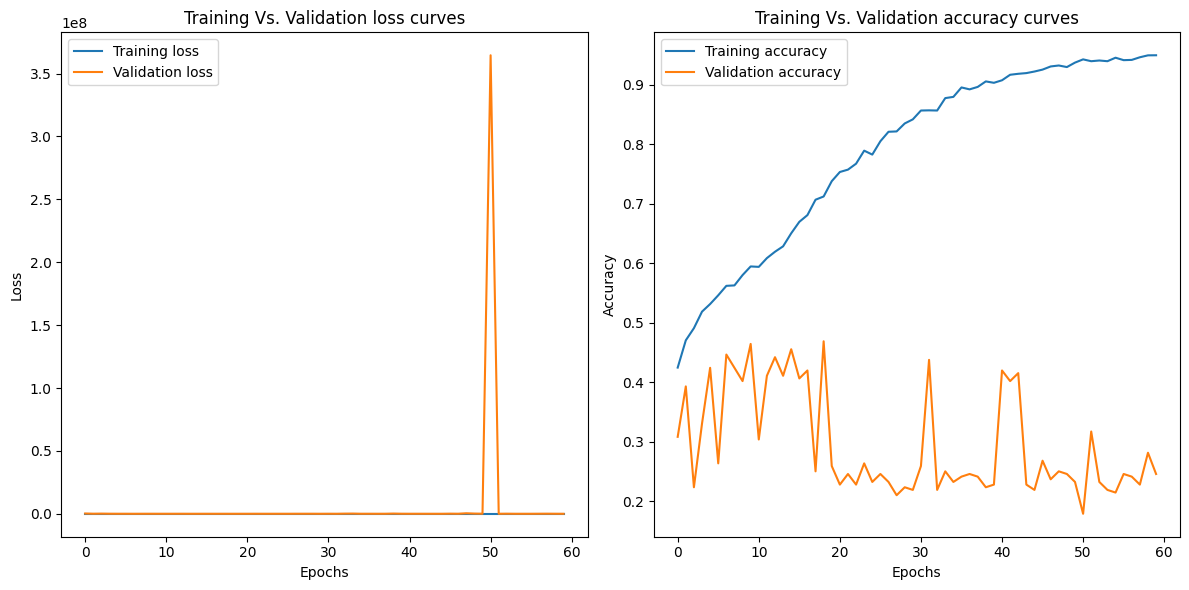

In [54]:
plot_loss_curves(resnet_history, classification = True, val_data = True)

## 7. Evaluate the model

Let's evaluate the model's performance using the validation data and plot the loss and accuracy curves.

In [ ]:
# Evaluate the model
cat_accuracy, top_k_accuracy, loss =  lenet_model.evaluate(val_dataset)

print(f'\n- Categorical_Accuracy: {cat_accuracy}\n- Top_k_Accuracy: {top_k_accuracy}\n- loss: {loss}')

NameError: name 'lenet_model' is not defined

In [ ]:
# Defing a function for plotting loss curves
def plot_loss_curves(history):
  plt.figure(figsize = (15, 6))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['Train Loss', 'Val Loss'])

  # Plot accuracy curves
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['Train Accuracy', 'Val Accuracy'])
  plt.show()


### Plot loss curves for model with data augmentation

In [ ]:
plot_loss_curves(lenet_model_history)

### Plot loss curves for model with cutmix augmentation

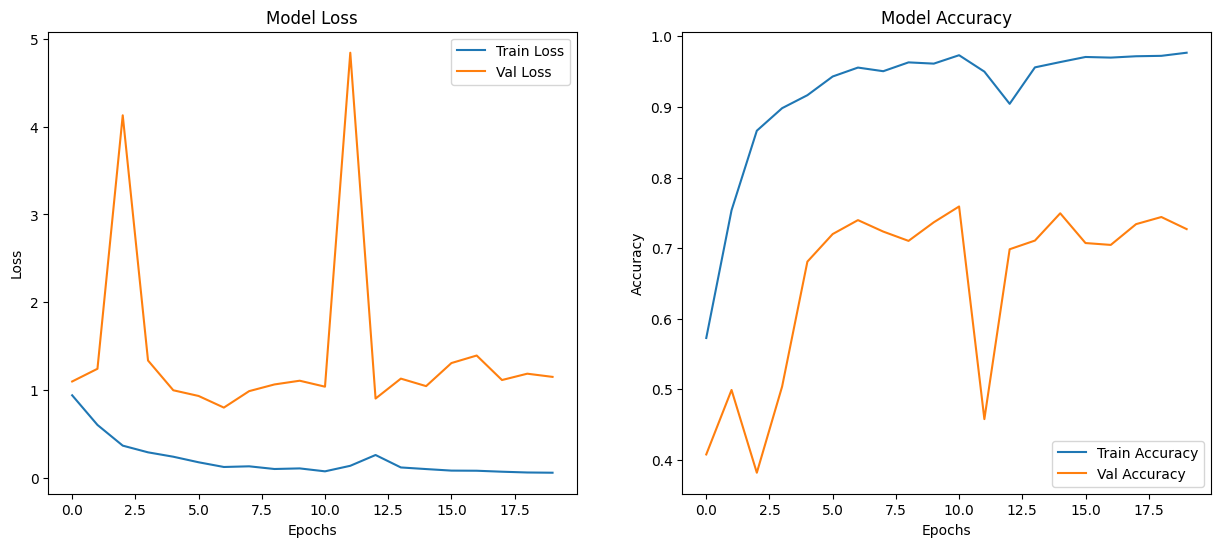

In [ ]:
plot_loss_curves(lenet_model_history_cutmix)

## 8. Save the model

In [ ]:
# Save the model
# lenet_model.save('lenet_model.h5')

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 9. Make predictions on a test image

Using the trained model, make predictions on the random images of unseen data.

In [ ]:
lenet_model = tf.keras.models.load_model('/content/drive/MyDrive/HumanEmotionDetection/lenet_model.h5')

### 9.1 Prediction on a sample random image

In [ ]:
# Turn the sample image into a tensor
sample_image_tensor = tf.constant(sample_image, dtype = tf.float32)

# Check image dimemsions
print(f'Sample image tensor dimensions: {sample_image_tensor.shape}')

# Add an extra dimension for batch size to represent our image as (batch_size, im_size, im_size, channels)(1, 224, 224, 3)
sample_image_tensor_dim = tf.expand_dims(sample_image_tensor, axis = 0)

# Print the dimensions after adding an extra dim
print(f'\nImage dimensions after adding extra dimension (batch_size, im_size, im_size, channels) -> {sample_image_tensor_dim.shape}\n')

# Let's now try to make prediction on the image
pred_probs = lenet_model.predict(sample_image_tensor_dim)

# Turn the probabilities into class labels
print(f'Predicted Class Label: {CLASS_NAMES[tf.argmax(pred_probs[0], axis = 0).numpy()].upper()}')


Sample image tensor dimensions: (224, 224, 3)

Image dimensions after adding extra dimension (batch_size, im_size, im_size, channels) -> (1, 224, 224, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
Predicted Class Label: HAPPY


(-0.5, 223.5, 223.5, -0.5)

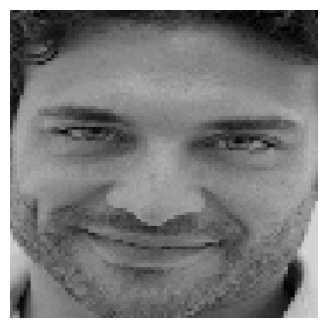

In [ ]:
# Load a sample image from the data
sample_image = cv2.imread('/content/Emotions Dataset/Emotions Dataset/test/happy/100610.jpg_brightness_1.jpg')

# Display the image
plt.figure(figsize = (4,4))
plt.imshow(sample_image)
plt.axis('off')

### 9.2. Making predictions on multiple random images

Let's functionize the above code to make it work for picking random images from the given directory and plotting them against the truth labels.

**Explanation:**

`[dirnames for (dirnames, _, _) in os.walk(data_dir)][1:]`

* `os.walk(data_dir):`

- `os.walk()` generates tuples for each directory in the specified directory tree `(data_dir)`.

Each tuple has three elements:

- `dir`: The current directory path.
- `filepath`: A list of subdirectories in that directory (we're not using it here, hence _ ).
- `filename`: A list of files in that directory (also ignored here with _ ).


**List Comprehension:**

* `[dir for (dir, _, _) in os.walk(data_dir)]` creates a list of directory paths `(dir)` generated by `os.walk()`.

* Only the directory names are retained, and subdirectory and file lists are ignored.


Sample Output:

`['/content/Emotions Dataset/Emotions Dataset/train/happy',`

 `'/content/Emotions Dataset/Emotions Dataset/train/angry',`

 `'/content/Emotions Dataset/Emotions Dataset/train/sad']`

In [ ]:
# Create a function to make predictions on multiple images picked at random
def make_prediction_random_images(data_dir, model):

  """
  This function makes the predictions on randomly picked images from the given
  directory and plots them against the truth labels.

    Args:
      - data_dir : it takes the path of the data
      - model : the model for making predictions
  """

  # Extract paths from the data directory
  paths = [dirnames for (dirnames, _, _) in os.walk(data_dir)][1:]

  # Setup figure size
  plt.figure(figsize = (12, 6))

  for i in range(6):
    # Plot 6 random images and make prediction on it using the model
    plt.subplot(2, 3, i + 1)

    # Randomly select a path from paths
    random_path = random.choice(paths)

    # Choose an image randomly from the random path
    random_image = random.choice(os.listdir(random_path))
    random_image_path = random_path + '/' + random_image

    # Read image
    read_image = cv2.imread(random_image_path)

    # Turn the image into tensor
    image_tensor = tf.constant(read_image, dtype = tf.float32)

    # Fetch the actual label from the image
    actual_label = random_path.split('/')[-1]

    # Add an extra dimension to the image
    image_tensor_dim = tf.expand_dims(image_tensor, axis = 0)

    # Make prediction on the image
    pred_probs = model.predict(image_tensor_dim)

    # Fetch predicted class label
    pred_class_label = CLASS_NAMES[tf.argmax(pred_probs[0], axis = 0).numpy()]

    # Display the images
    plt.imshow(image_tensor/255.)
    plt.title(f'Actual Label : {actual_label}\nPredicted Label : {pred_class_label}\nPrediction Probabilty: {np.round(max(pred_probs[0]) * 100, 2)}%')

  plt.tight_layout()

  return None

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


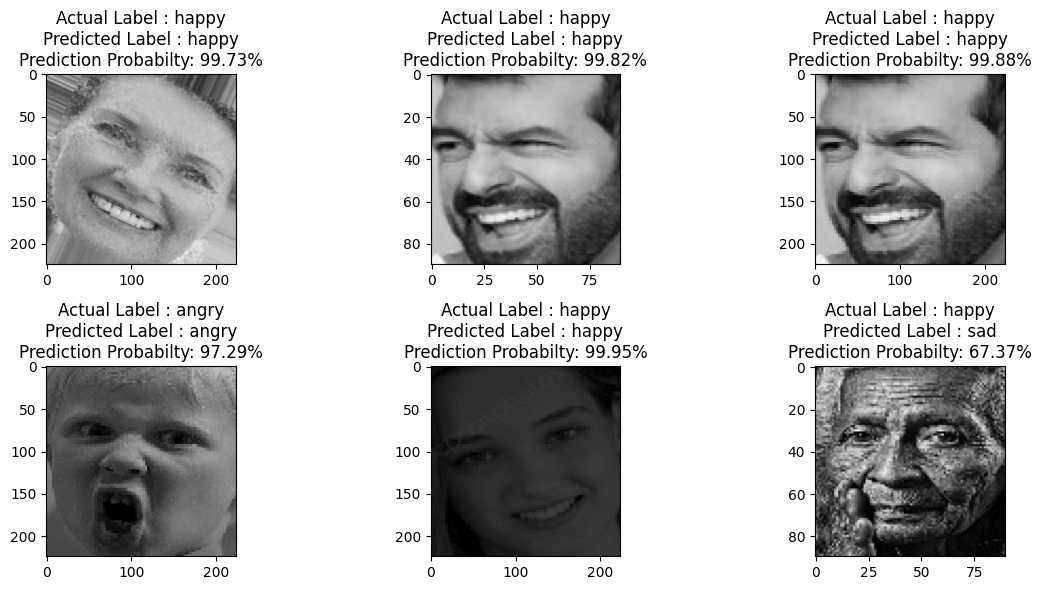

In [ ]:
make_prediction_random_images(val_dir, lenet_model)

### 9.3 Create the Confusion Matrix

In [ ]:
# Make predictions on validation dataset
predicted = []
labels = []

for im, label in val_dataset:
  labels.append(label)
  predicted.append(lenet_model(im))

In [ ]:
print(len(labels), labels)

72 [<tf.Tensor: shape=(32, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)>, <tf.Tensor: shape=(32, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]

We will now process the true labels (labels) and predicted outputs (predicted) of a model to prepare them for evaluation.

1. `np.argmax(labels, axis=-1):`

* Converts the one-hot encoded true labels into their class indices along the last axis.

2. `flatten():`

* Flattens the arrays into 1D to simplify comparison.

3. `Concatenation:`

* Combines the processed labels and predictions from all batches (except the last and the last batch separately) into single 1D arrays:
* `lab:` Contains the true class indices.
* `preds:` Contains the predicted class indices.

The result is two 1D arrays (lab and preds) that are ready for metrics computation, such as accuracy, precision, or recall.

In [ ]:
# We will now process the true labels (labels) and predicted outputs (predicted)
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])
preds = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])

print(np.argmax(labels[:-1], axis = -1).flatten())
print(np.argmax(predicted[:-1], axis = -1).flatten())

[1 1 0 ... 2 0 1]
[0 1 0 ... 2 2 1]


In [ ]:
# Let's functionize making prediction
def make_predictions(model, dataset):
  """
    Generates predictions for a given dataset using the specified model.

    Args:
        model (tf.keras.Model or similar): The trained model used for making predictions.
        dataset (tf.data.Dataset or iterable): A dataset containing image-label pairs.

    Returns:
        tuple:
            - y_true (numpy.ndarray): Flattened array of true labels.
            - y_pred (numpy.ndarray): Flattened array of predicted labels.

    Note:
        Ensure the dataset provides labels in one-hot encoded format,
        as `np.argmax` is used to convert them into class indices.
    """

  labels = []
  predictions = []

  for image, label in dataset:
    labels.append(label)
    predictions.append(model(image))

  y_true = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])
  y_pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])

  return y_true, y_pred



### Make predictions for model with data augmentation

In [ ]:
y_true, y_pred = make_predictions(model = lenet_model,
                                  dataset = val_dataset)

### Make predictions for model with cutmix data augmentation

[[305 101 109]
 [ 33 847 126]
 [ 49 127 581]]


Text(0.5, 58.7222222222222, 'Predicted')

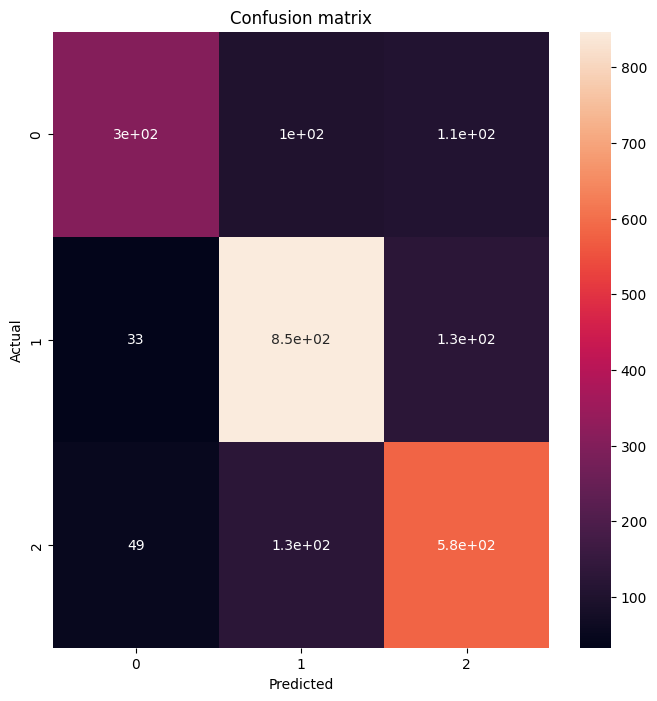

In [ ]:
# Build the confusion matrix
cm = confusion_matrix(lab, preds)
print(cm)

plt.figure(figsize = (8, 8))
sns.heatmap(cm, annot= True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

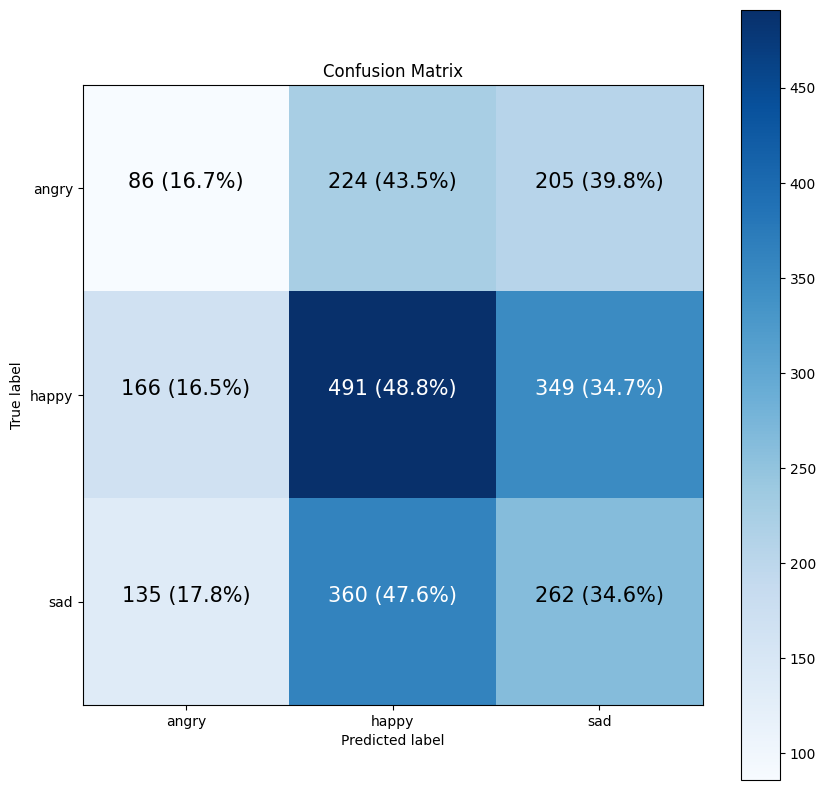

In [ ]:
make_confusion_matrix(y_true = y_true,
                      y_pred = y_pred,
                      classes = CLASS_NAMES)

## TensorFlow Records

* Why TensorFlow Records?

`TFRecord (TensorFlow Records)` is a binary file format used to store large amounts of structured data efficiently for TensorFlow training. It offers:

* Efficiency: Stores data in a compact, serialized format, reducing I/O overhead.
* Faster Data Loading: Works well with tf.data API for efficient input pipelines.
* Flexibility: Supports images, text, and structured data using tf.train.Example.

`Compression:` Can use GZIP or ZLIB to reduce storage size.
🔹 Example Workflow:

1. Convert data into `tf.train.Example`.
2. Write to a `.tfrecord` file.
3. Read using `tf.data.TFRecordDataset.`

In [ ]:
# Convert batched datasets into individual elements, which is useful before serializing them into TFRecord format.
training_dataset = train_dataset.unbatch()
validation_dataset = val_dataset.unbatch()

In [ ]:
def create_example(image, label):
    """
    Converts an image and label into a serialized TFRecord example.

    Args:
        image (bytes): The raw image data in byte format.
        label (numpy array): One-hot encoded label.

    Returns:
        Serialized Example in TFRecord format.
    """

    # Convert the image to a bytes feature (stores raw image data as bytes)
    bytes_feature = Feature(
        bytes_list=BytesList(value=[image])
    )

    # Convert the label to an integer feature (stores the class index)
    int_feature = Feature(
        int64_list=Int64List(value=[np.argmax(label)])  # Convert one-hot to class index
    )

    # Create a TFRecord Example containing image and label features
    example = Example(
        features=Features(
            feature={
                'images': bytes_feature,
                'labels': int_feature
            }
        )
    )

    # Serialize the Example to a string format for storage in TFRecord
    return example.SerializeToString()


In [ ]:
# Define the number of shards (separate TFRecord files) to split the dataset into
NUM_SHARDS = 10

# Define the file path format for storing each shard
# {:02d} ensures shard indices are zero-padded (e.g., 'shard_00.tfrecord', 'shard_01.tfrecord', ...)
PATH = 'tfrecords/shard_{:02d}.tfrecord'


In [ ]:
def encode_image(image, label):
    """
    Encodes an image as a JPEG format for storage in TFRecord.

    Args:
        image (Tensor): Input image tensor.
        label (Tensor): Corresponding label.

    Returns:
        Tuple (encoded image as bytes, label).
    """

    # Cast the image to tf.uint8 to ensure proper encoding
    image = tf.cast(image, tf.uint8)

    # Encode the image in JPEG format to reduce storage size
    image = tf.io.encode_jpeg(image)

    # Return the encoded image and the label
    return image, label


In [ ]:
# Apply the encode_image function to every element in training_dataset.
encoded_dataset = training_dataset.map(encode_image)

In [ ]:
import os  # Ensure os module is imported

# Create the 'tfrecords' directory if it doesn't exist
# `exist_ok=True` prevents errors if the directory already exists
os.makedirs('tfrecords', exist_ok=True)

# Iterate over the number of shards to split the dataset
for shard_number in range(NUM_SHARDS):

    # Split the dataset into `NUM_SHARDS` parts
    # Each shard contains a subset of the dataset
    sharded_dataset = (
        encoded_dataset
        .shard(NUM_SHARDS, shard_number)  # Assigns each example to a specific shard
        .as_numpy_iterator()  # Converts the dataset to an iterator for easier processing
    )

    # Open a TFRecord file for the current shard
    with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:

        # Iterate through the examples in the current shard
        for image, label in sharded_dataset:

            # Serialize and write the example to the TFRecord file
            file_writer.write(create_example(image, label))


If you want to write the records onto drive refer below code

In [ ]:
# from google.colab import drive
# import os
# import tensorflow as tf

# # Mount Google Drive
# drive.mount('/content/drive')

# # Define the Google Drive path for saving TFRecords
# GDRIVE_PATH = '/content/drive/My Drive/tfrecords'

# # Create the directory in Google Drive if it doesn't exist
# os.makedirs(GDRIVE_PATH, exist_ok=True)

# # Iterate over the number of shards to split the dataset
# for shard_number in range(NUM_SHARDS):

#     # Split the dataset into `NUM_SHARDS` parts
#     sharded_dataset = (
#         encoded_dataset
#         .shard(NUM_SHARDS, shard_number)
#         .as_numpy_iterator()
#     )

#     # Define the full path for each TFRecord file
#     shard_path = os.path.join(GDRIVE_PATH, f'shard_{shard_number:02d}.tfrecord')

#     # Write the TFRecord file to Google Drive
#     with tf.io.TFRecordWriter(shard_path) as file_writer:
#         for image, label in sharded_dataset:
#             file_writer.write(create_example(image, label))

# print(f"TFRecords saved in {GDRIVE_PATH}")


In [ ]:
# Create a TensorFlow dataset by reading the TFRecord files
recons_dataset = tf.data.TFRecordDataset(
    filenames=[PATH.format(p) for p in range(NUM_SHARDS)]
)


In [ ]:
def parse_tfrecords(example):
    """
    Parses a single TFRecord example into an image and label.

    Args:
        example (tf.Tensor): A serialized TFRecord example.

    Returns:
        Tuple (decoded image as float32, integer label).
    """

    # Define the structure of the stored TFRecord features
    feature_description = {
        "images": tf.io.FixedLenFeature([], tf.string),  # Image stored as a byte string
        "labels": tf.io.FixedLenFeature([], tf.int64)    # Label stored as an integer
    }

    # Parse the serialized example to extract features
    example = tf.io.parse_single_example(example, feature_description)

    # Decode the JPEG image and convert it to float32 (values scaled to [0,1])
    example["images"] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(
            example["images"],  # Decode the stored JPEG image
            channels=3  # Ensure it's a 3-channel RGB image
        ),
        dtype=tf.float32  # Normalize pixel values to range [0,1]
    )

    # Return the decoded image and its corresponding label
    return example['images'], example['labels']


Reading TensorFlow records from google drive

In [ ]:
# from google.colab import drive
# import tensorflow as tf
# import os

# # Mount Google Drive to access files
# drive.mount('/content/drive')

# # Define the path where your TFRecord files are stored in Google Drive
# GDRIVE_PATH = '/content/drive/My Drive/tfrecords'

# # List of TFRecord file paths in Google Drive
# filenames = [os.path.join(GDRIVE_PATH, f'shard_{p:02d}.tfrecord') for p in range(NUM_SHARDS)]

# # Create a TFRecordDataset to read from Google Drive
# recons_dataset = tf.data.TFRecordDataset(filenames=filenames)

# # Define the parsing function (same as before)
# def parse_tfrecords(example):
#     """
#     Parses a single TFRecord example into an image and label.

#     Args:
#         example (tf.Tensor): A serialized TFRecord example.

#     Returns:
#         Tuple (decoded image as float32, integer label).
#     """
#     feature_description = {
#         "images": tf.io.FixedLenFeature([], tf.string),
#         "labels": tf.io.FixedLenFeature([], tf.int64),
#     }

#     # Parse the serialized example to extract features
#     example = tf.io.parse_single_example(example, feature_description)

#     # Decode the JPEG image and convert it to float32
#     example["images"] = tf.image.convert_image_dtype(
#         tf.io.decode_jpeg(example["images"], channels=3),
#         dtype=tf.float32
#     )

#     return example['images'], example['labels']

# # Apply the parsing function to the dataset
# parsed_dataset = recons_dataset.map(parse_tfrecords)

# # Example: Iterate through the dataset and fetch parsed images and labels
# for image, label in parsed_dataset.take(1):
#     print(image.shape, label)


In [ ]:
# Parse the TFRecord dataset, batch it, and prefetch it for efficient training
parsed_dataset = (
    recons_dataset  # The original dataset loaded from TFRecord files

    # Apply the `parse_tfrecords` function to decode each record (image and label)
    .map(parse_tfrecords)  # Maps the parse function to the dataset

    # Group the parsed data into batches for more efficient processing during training
    .batch(CONFIGURATION["BATCH_SIZE"])  # Batches the dataset with the specified batch size

    # Prefetch the next batch of data while training on the current batch, improving throughput
    .prefetch(tf.data.AUTOTUNE)  # Automatically tunes the prefetch buffer size for optimal performance
)


In [ ]:
# Lets create Lenet Model for TensorFlow Records
lenet_model_tfrecords = tf.keras.models.Sequential([
    InputLayer(shape = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3)),
    resize_rescaling_layers,

    # 1st Conv2D Layer
    Conv2D(filters = CONFIGURATION['N_FILTERS'],
           kernel_size = CONFIGURATION['KERNEL_SIZE'],
           strides = CONFIGURATION['N_STRIDES'],
           kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE']),
           activation = 'relu'),

    BatchNormalization(),
    MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'],
              strides = CONFIGURATION['N_STRIDES'] * 2),
    Dropout(rate = CONFIGURATION['DROPOUT_RATE']),

    # 2nd Conv2D Layer
    Conv2D(filters = CONFIGURATION['N_FILTERS'] * 2 + 4,
           kernel_size = CONFIGURATION['KERNEL_SIZE'],
           strides = CONFIGURATION['N_STRIDES'],
           kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE']),
           activation = 'relu'),

    BatchNormalization(),
    MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'],
              strides = CONFIGURATION['N_STRIDES'] * 2),

    # Flatten Layer
    Flatten(),

    # 1st Dense Layer
    Dense(units = CONFIGURATION['N_DENSE_1'],
          activation = 'relu',
          kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),

    BatchNormalization(),
    Dropout(rate = CONFIGURATION['DROPOUT_RATE']),

    # 2nd Dense Layer
    Dense(units = CONFIGURATION['N_DENSE_2'],
          activation = 'relu',
          kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),

    BatchNormalization(),

    # Output Layer
    Dense(units = CONFIGURATION['NUM_CLASSES'],
          activation = 'softmax')
])

lenet_model_cutmix.summary()

In [ ]:
# Compile the model
loss_function = SparseCategoricalCrossentropy()
metrics = [SparseCategoricalAccuracy(name = 'accuracy')]

lenet_model_tfrecords.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
# Fit the model
lenet_history_tfrecords = lenet_model_tfrecords.fit(
    parsed_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1
)